In [1]:
# import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import cv2 as cv

load_dir = Path("/archive/savkin/raw_datasets/MIPT/TransPath_data/maps")

* maze
* random noise
* street maps
* 

## Random Maps

In [5]:
def load_map(path):
    with open(path, "r") as f:
        lines = f.readlines()
    height = int(lines[1].split()[1])
    width = int(lines[2].split()[1])
    cells = np.zeros((height, width))
    for i, line in enumerate(lines[4:]):
        for j, char in enumerate(line.strip()):
            if char == '@':
                cells[i, j] = 1
            elif char == '.' or char == "T":
                cells[i, j] = 0
            else:
                ValueError('Incorrect cell type')
    return cells

In [ ]:
load_dir = Path("/archive/savkin/raw_datasets/MIPT/TransPath_data/maps")

map = load_map(load_dir / "random-map" / "random512-40-9.map")

plt.imshow(map)
plt.show()

In [ ]:
random_maps_dir = load_dir / "random-map"
map_densities = np.arange(10, 41, 5)
random_maps = []
for density in tqdm(map_densities):
    for i in range(10):
        map = load_map(random_maps_dir / f"random512-{density}-{i}.map")
        random_maps.append(map)

random_maps = np.array(random_maps)
random_maps.shape

In [ ]:
np.save(random_maps_dir / "all_rand_maps.npy", random_maps)

## Street Maps

In [7]:
street_maps_dir = load_dir / "street-map"
street_maps = defaultdict(list)
for path in tqdm(street_maps_dir.iterdir()):
    map = load_map(path)
    edge_size = map.shape[0]
    street_maps[edge_size].append(map)

90it [00:09,  9.26it/s]


In [ ]:
for edge_size, maps in street_maps.items():
    np.save(load_dir / "my_maps" / f"street_maps_{edge_size}.npy", maps)

## Tile MP Dataset

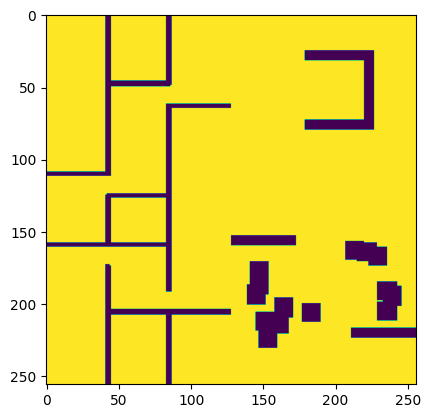

In [110]:
path = "/home/savkin/MIPT/2024/TransPath Project/planning-datasets/data/mpd/all_128x2.npz"

data = np.load(path)

plt.imshow(data["arr_0"][0])
plt.show()

## Augmentations

In [23]:
maps = np.load(load_dir / "my_maps" / f"street_maps_1024.npy")
maps.shape

(30, 1024, 1024)

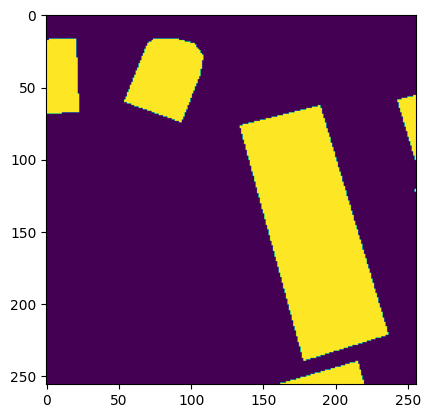

In [63]:

def get_random_crop(image, crop_height, crop_width):

    max_x = image.shape[1] - crop_width
    max_y = image.shape[0] - crop_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = image[y: y + crop_height, x: x + crop_width]

    return crop



# plt.imshow(maps[0], vmin=0, vmax=1)
# plt.show()


plt.imshow(get_random_crop(maps[0], 256, 256) , vmin=0, vmax=1)
plt.show()

In [19]:
from scipy import ndimage

map = maps[0]

augmented_maps = []

for map in maps[:5]:
    rotation_types = [cv.ROTATE_90_CLOCKWISE, cv.ROTATE_180, cv.ROTATE_90_COUNTERCLOCKWISE]
    fliped_map = cv.flip(map, 0)
    augmented_maps = augmented_maps + [
        map,
        *[cv.rotate(map, rotation_type) for rotation_type in rotation_types],
        fliped_map,
        *[cv.rotate(fliped_map, rotation_type) for rotation_type in rotation_types]
    ]


# plt.imshow(map, vmin=0, vmax=1)
# plt.show()


# plt.imshow(cv.flip(map, 0) , vmin=0, vmax=1)
# plt.show()

# plt.imshow(cv.rotate(map, cv.ROTATE_90_CLOCKWISE), vmin=0, vmax=1)
# plt.show()


# plt.imshow(cv.rotate(map, cv.ROTATE_180), vmin=0, vmax=1)
# plt.show()

# plt.imshow(cv.rotate(map, cv.ROTATE_90_COUNTERCLOCKWISE), vmin=0, vmax=1)
# plt.show()

## Generating start and goal nodes

Calc map hardness

In [ ]:
## обязательно проверь сложность карт!!!!!! Желательно прям добавить её к каждой карте!!!! Раз делаешь BFS то это совсем просто!!!

## Generate tasks

In [ ]:
import numpy as np

def gen_rand_map(size, p=0.5):
    map = np.random.binomial(1, p, size=(size, size))
    return map

gen_rand_map(20, 0.9)

In [ ]:
import random

def generate_maze(width, height):
    # Initialize the maze grid as a 2D array of walls ('#') and cells (' ')
    maze = [['#' for _ in range(width)] for _ in range(height)]

    # Function to carve paths recursively using DFS
    def carve(x, y):
        # Define possible directions to move: right, left, down, up
        directions = [(2, 0), (-2, 0), (0, 2), (0, -2)]
        random.shuffle(directions)  # Randomize directions to ensure maze randomness
        
        for dx, dy in directions:
            nx, ny = x + dx, y + dy  # Calculate next cell coordinates
            if 0 < nx < width-1 and 0 < ny < height-1 and maze[ny][nx] == '#':  # Check boundaries and if cell is not carved
                maze[ny][nx] = ' '  # Carve the new cell
                maze[ny - dy // 2][nx - dx // 2] = ' '  # Carve the wall between the current cell and the new cell
                carve(nx, ny)  # Recursively carve from the new cell

    # Start the maze from the upper-left corner, or change this to be any odd indices cell to start elsewhere
    maze[1][1] = ' '
    carve(1, 1)

    # Return the maze grid as a list of strings for easy display
    return [" ".join(row) for row in maze]

def print_maze(maze):
    for row in maze:
        print(row)

# Example of generating a 21x21 maze
maze = generate_maze(51, 51)
print_maze(maze)